# Team 3 Final Project - Modeling

We will be using a variety of Machine Learning Models in an unsupervised manner to produce a Collaborative Filtering based Recommender System.

K Nearest Neigbors will produce the actual recommendations based on cosine similarity between anime titles. Recommendations will be made based on user's last watched anime, this will be the query for KNN. Titles already watched (completed) by the user will be excluded from the dataset for KNN (don't want to recommend already watched titles). The K (default 10) nearest neighbors to the last watched title will be the recommendations.

BERT Model (Bi-Directional Encoder Representations from Transformers) - Default Pre-Trained BERT model will be used on the synopsis table to generate a vector embedding or semantic representation that can be used by KNN to produce more distinct recommendations. **Note: This will significantly increase the complexity of the project and will only be used if there is enough time to implement**

K-Means Clustering - There are currently 36 unique genres that may be too similar and titles can be attached to many genres. We want to simply the genres by generating clusters that will serve to reduce the dimenionality from 36 genres to k - clusters.

In [1]:
!pip install pyathena

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
# This is for MAR@K metrics
#!pip install recmetrics

In [3]:
#!pip install ml_metrics

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from botocore.exceptions import ClientError
import sagemaker
import pyathena as pa
from pyathena.pandas.cursor import PandasCursor
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [5]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
# Athena modeling bucket
s3_modeling_dir = 's3://ads508team3/modeling/'
# Athena staging bucket
s3_staging_dir = 's3://ads508team3/athena-staging/'

In [7]:
# Create Connection for pyathena
conn = pa.connect(region_name=region, s3_staging_dir=s3_staging_dir)
cursor = pa.connect(s3_staging_dir=s3_staging_dir, region_name='us-east-1',cursor_class=PandasCursor).cursor()
dbname = 'myanimelist'
table_list = ['animelist', 'anime', 'synopsis', 'ratings', 'watching_status']

## Import training set

In [8]:
# Download Files from S3

s3 = boto3.resource('s3')

try:
    s3.Bucket('ads508team3').download_file('modeling/training.csv', 'Data/training.csv')
    s3.Bucket('ads508team3').download_file('modeling/semantics.csv', 'Data/semantics.csv')
    s3.Bucket('ads508team3').download_file('modeling/anime_subset.csv', 'Data/anime_subset.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [9]:
training = pd.read_csv('Data/training.csv')

In [10]:
training

,user_id,anime_id,user_rating,watching_status,watched_episodes,mal_id,aggregated_score,episodes,rating,ranked,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,336145,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,228773,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,61090,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,26848,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,195185,2251,8,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999991,300428,13503,0,4,0,13503,6.509999,11.0,3,13708.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999992,30459,34369,0,4,0,34369,6.509999,5.0,3,14403.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0
999993,275530,7779,0,4,0,7779,6.210000,52.0,2,7295.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999994,272555,40406,0,4,0,40406,6.509999,16.0,1,15754.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
training.columns

Index(['user_id', 'anime_id', 'user_rating', 'watching_status',
       'watched_episodes', 'mal_id', 'aggregated_score', 'episodes', 'rating',
       'ranked', 'popularity', 'members', 'score_10', 'score_9', 'score_8',
       'score_7', 'score_6', 'score_5', 'score_4', 'score_3', 'score_2',
       'score_1', 'days_since_aired', 'Action', 'Adventure', 'Cars', 'Comedy',
       'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem',
       'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Music.1', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri', 'Movie', 'Music.2',
       'Music.3', 'ONA', 'OVA', 'Other', 'Special', 'TV'],
      dtype='object')

## Import anime subset

Used for KNN of titles

In [12]:
anime_subset = pd.read_csv('Data/anime_subset.csv')

In [13]:
anime_subset

,mal_id,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,1,8.780000,26.0,5,28.0,39,1251960,229170.0,182126.0,131625.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,8.390000,1.0,5,159.0,518,273145,30043.0,49201.0,49505.0,...,0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,8.240000,26.0,3,266.0,201,558913,50229.0,75651.0,86142.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,7,7.270000,26.0,3,2481.0,1467,94683,2182.0,4806.0,10128.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,6.980000,52.0,2,3710.0,4369,13224,312.0,529.0,1242.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,6.509999,2.0,6,7896.0,13116,354,39.0,71.0,92.0,...,0,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0
17558,48483,6.509999,2.0,6,7896.0,17562,7010,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17559,48488,6.509999,2.0,5,7896.0,17558,11309,1.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17560,48491,6.509999,2.0,3,7896.0,17565,1386,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
anime_subset.set_index(['mal_id'], inplace=True)

### Standardization and Min-max scaling variables

In [15]:
anime_subset.columns

Index(['score', 'episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired',
       'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Music.1', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi',
       'Yuri', 'Movie', 'Music.2', 'Music.3', 'ONA', 'OVA', 'Other', 'Special',
       'TV'],
      dtype='object')

In [16]:
# Drop Music.2 and Music.3
anime_subset = anime_subset.drop(columns=['Music.2', 'Music.3'])

In [17]:
# Standard Scale the aggregated user score
anime_subset['score'] = StandardScaler().fit_transform(anime_subset[['score']])

In [18]:
# Min-max scaling
mm_scaling_cols = ['episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired']
anime_subset[mm_scaling_cols] = MinMaxScaler().fit_transform(anime_subset[mm_scaling_cols])

In [19]:
# Post scaling
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Clustering using Kmeans

We want to cluster the titles into distinct groups to prevent same similarity measures when using KNN. This will also reduce dimensionality of the dataset by replacing the genre columns with these clusters

In [20]:
genres_list = ['Dementia', 'Shounen Ai', 'Adventure', 'Music', 'Martial Arts', 'Kids',
               'Sports', 'Action', 'Cars', 'Hentai', 'Slice of Life', 'Vampire', 'Seinen',
               'Thriller', 'Romance', 'Samurai', 'Historical', 'Drama', 'Unknown', 'Psychological', 'Comedy', 
               'Mystery', 'Josei', 'Military', 'Ecchi', 'Magic', 'Supernatural', 'Yaoi', 'Shounen', 'Sci-Fi', 
               'Super Power', 'Demons', 'Parody', 'Horror', 'Police', 'Fantasy', 'Game', 'Shoujo', 'Harem',
               'School', 'Space', 'Mecha', 'Shoujo Ai', 'Yuri']

In [21]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Elbow curve')

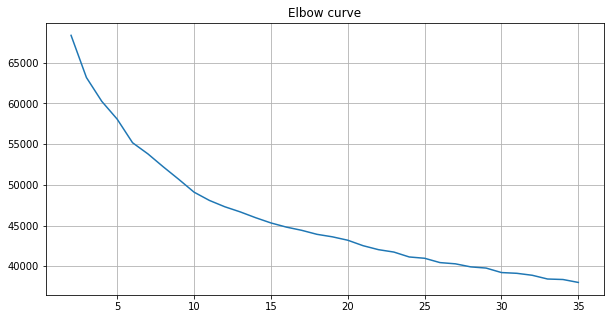

In [22]:
distorsions = []
for k in range(2, 36):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(anime_subset)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 36), distorsions)
plt.grid(True)
plt.title('Elbow curve')

### K-Means Results

Based on inertia, 10 clusters will best represent the anime titles and the cluster assignments will replace the genres

In [23]:
km_10 = KMeans(10)
g_clusters = km_10.fit(anime_subset)

In [24]:
anime_subset['cluster'] = g_clusters.labels_

In [25]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV,cluster
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,9
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,7
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [26]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(anime_subset[['cluster']])
cluster_10 = pd.DataFrame(enc.transform(anime_subset[['cluster']]), columns=['g_cluster_' + str(i) for i in range(1, 11)])

In [27]:
cluster_10 = cluster_10.astype('int')

In [28]:
# need the index (mal_id) from the genres dataframe
cluster_10.index = anime_subset.index

In [29]:
cluster_10

,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
48481,0,0,0,0,0,0,0,1,0,0
48483,1,0,0,0,0,0,0,0,0,0
48488,1,0,0,0,0,0,0,0,0,0


## Replace the genres columns with clusters

Dimensionality was reduced from 74 to 39 columns

In [30]:
# drop the original genres columns
training_w_clusters = training.drop(columns=genres_list)
training_w_clusters = pd.merge(training_w_clusters, cluster_10, left_on='mal_id', right_index=True)
training_w_clusters.drop(columns=['mal_id'], inplace=True)

In [31]:
training_w_clusters.sort_values(['user_id']).set_index(['user_id', 'anime_id'])

user_rating  watching_status  watched_episodes  \
user_id anime_id                                                   
0       269                 9                3                64   
1       33486               8                2                25   
3       10379               8                2                13   
        9863                9                2                77   
        71                  7                2                24   
...                       ...              ...               ...   
353398  17247               8                3                 3   
        1571                7                2                25   
        36144               0                1                 0   
        32979               7                2                13   
353401  34662               0                6                 0   

                  aggregated_score  episodes  rating  ranked  popularity  \
user_id anime_id                                                           
0       269                   7.80     366.0       3   818.0          33   
1       33486                 8.33      25.0       3   203.0          13   
3       10379                 8.60      13.0       3    67.0         738   
        9863                  8.25      77.0       3   262.0         804   
        71                    7.65      24.0       5  1146.0         322   
...                            ...       ...     ...     ...         ...   
353398  17247                 7.15      12.0       4  3003.0         553   
        1571                  7.81      25.0       3   811.0         766   
        36144                 7.17      24.0       5  2907.0        2034   
        32979                 7.68      13.0       3  1084.0         949   
353401  34662                 7.16      25.0       5  2937.0         402   

                  members  score_10  ...  g_cluster_1  g_cluster_2  \
user_id anime_id                     ...                             
0       269       1286382  116063.0  ...            0            0   
1       33486     1611771  188165.0  ...            0            0   
3       10379      200904   23877.0  ...            0            0   
        9863       185346   11534.0  ...            0            0   
        71         411230   17675.0  ...            0            0   
...                   ...       ...  ...          ...          ...   
353398  17247      264089    7926.0  ...            0            0   
        1571       194354   11328.0  ...            0            0   
        36144       59132    1023.0  ...            0            0   
        32979      156048    5540.0  ...            0            0   
353401  34662      339526   12121.0  ...            0            0   

                  g_cluster_3  g_cluster_4  g_cluster_5  g_cluster_6  \
user_id anime_id                                                       
0       269                 0            0            0            0   
1       33486               0            0            0            0   
3       10379               1            0            0            0   
        9863                1            0            0            0   
        71                  0            0            0            0   
...                       ...          ...          ...          ...   
353398  17247               0            0            0            0   
        1571                1            0            0            0   
        36144               0            0            0            0   
        32979               1            0            0            0   
353401  34662               0            0            0            0   

                  g_cluster_7  g_cluster_8  g_cluster_9  g_cluster_10  
user_id anime_id                                                       
0       269                 0            0            0             1  
1       33486               0            0            0             1  
3       

In [32]:
# Do the same for anime_subset
anime_clusters = anime_subset.drop(columns=genres_list)
anime_clusters = pd.merge(anime_clusters, cluster_10, left_on='mal_id', right_index=True)

In [33]:
anime_clusters

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0,0,0,0,0,1
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,0,0,0,0,0,1
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0,0,0,0,0,1
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0,0,0,0,0,1
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0,0,0,1,0,0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,1,0,0,0,0,0,0,0,0,0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,1,0,0,0,0,0,0,0,0,0


# K Nearest Neighbors Model

Since we're using KNN in an unsupervised manner (no labels, no classifications) we will use NearestNeigbors vs KNeighborsClassifier

**Notes**
KNN will use the anime_subset with cluster assignments

In [34]:
knn = NearestNeighbors(metric="cosine")
knn.fit(anime_clusters)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Test Query

The test query will include itself as a recommendation, this will be excluded for final inferences

In [35]:
# Load the original anime table for title information from athena
anime = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'anime')).as_pandas()

### Query Title

In [36]:
anime[anime['mal_id'] == anime_clusters.iloc[1, :].name]

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_10,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [37]:
distances, titles = knn.kneighbors(anime_clusters.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [38]:
# Sort by distances, smallest to largest
distances

array([[1.11022302e-16, 8.25259507e-05, 1.03038202e-04, 2.84635441e-04,
        2.96161078e-04, 3.18006897e-04, 3.23677857e-04, 3.44557465e-04,
        3.66553082e-04, 3.81006157e-04]])

In [39]:
# Recommendation rows ordered by distances
list(titles[0])

[1, 2215, 2813, 6229, 8139, 14023, 2373, 5897, 11127, 14309]

In [40]:
# Convert rows to anime_ids
anime_clusters.iloc[list(titles[0]), :].index.tolist()

[5, 2418, 5205, 7472, 25537, 37055, 4282, 6675, 31812, 37515]

### Recommended Titles based on Query

In [41]:
anime[anime['mal_id'].isin(anime_clusters.iloc[list(titles[0]), :].index.tolist())][['mal_id', 'name', 'genres']]

,mal_id,name,genres
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
2215,2418,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai"
2373,4282,Kara no Kyoukai 5: Mujun Rasen,"Action, Mystery, Supernatural, Drama, Romance,..."
2813,5205,Kara no Kyoukai 7: Satsujin Kousatsu (Go),"Action, Mystery, Supernatural, Romance, Thriller"
4690,6675,Redline,"Action, Sci-Fi, Cars, Sports"
5022,7472,Gintama Movie 1: Shinyaku Benizakura-hen,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
9343,25537,Fate/stay night Movie: Heaven's Feel - I. Pres...,"Action, Fantasy, Magic, Supernatural"
11127,31812,Kuroshitsuji Movie: Book of the Atlantic,"Action, Mystery, Comedy, Historical, Demons, S..."
12787,37055,Youjo Senki Movie,"Action, Military, Magic"
13073,37515,Made in Abyss Movie 2: Hourou Suru Tasogare,"Sci-Fi, Adventure, Mystery, Drama, Fantasy"


# Adding NLP Embeddings of Anime Synopsis Data using BERT

BERT model inferences are on the Team3_Modeling_BERT.ipynb notebook. See the note

In [42]:
# Pull Synopsis from Athena
synopsis = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'synopsis')).as_pandas()
# Semantics is downloaded from S3
embeddings = pd.read_csv('Data/semantics.csv')

In [43]:
embeddings = pd.concat([synopsis[['mal_id']], embeddings], axis=1)
embeddings.set_index(['mal_id'], inplace=True)

In [44]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
mal_id,,,,,,,,,,,,,,,,,,,,,
831,-0.338000,0.280912,0.316794,-0.081068,0.229358,-0.153148,-0.447823,0.525362,0.265396,-0.106113,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
832,-0.025266,-0.049519,0.394098,-0.144688,0.058020,-0.056215,-0.152939,0.453019,0.189982,0.088776,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
833,-0.050121,0.361339,0.314151,0.030035,-0.018952,-0.169436,0.143299,0.653574,0.067216,0.066807,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
834,-0.277991,-0.150378,0.051548,-0.052691,0.007375,-0.371882,0.255686,-0.042258,0.262719,0.135156,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
835,-0.460624,-0.038628,0.111783,-0.103765,-0.212746,0.000713,0.400580,0.219770,0.255605,-0.086178,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,-0.224903,-0.046536,0.105933,0.138320,0.308536,-0.486385,-0.147109,0.669781,-0.125035,-0.394241,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,-0.334284,0.088137,-0.028772,-0.419087,0.146186,0.032084,0.498137,0.263860,0.312464,-0.129219,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,-0.818853,-0.930334,-0.327279,-0.424246,-0.954531,-0.041453,0.148937,-0.311416,0.090937,0.274852,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [45]:
# join embeddings on anime_clusters dataframe
anime_embeddings = pd.merge(anime_clusters, embeddings, left_index=True, right_index=True, how='left')

In [46]:
anime_embeddings

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,758,759,760,761,762,763,764,765,766,767
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,-0.765926,-0.410303,0.255224,-0.295238,-0.368097,0.132518,-0.106798,-0.026372,0.362982,0.339029
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,-0.423419,-0.413418,0.561263,-0.349052,-0.418017,0.045889,-0.115350,0.011727,0.244321,-0.276459
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,-0.613344,-0.267247,0.155343,-0.365929,-0.062809,0.101678,-0.244463,0.005783,0.078354,0.018852
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,-0.419727,-0.188446,0.387873,-0.266732,-0.014385,0.036534,0.120315,0.219251,0.044967,-0.092481
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,-0.284597,-0.072100,0.169327,-0.304004,-0.153344,0.056951,-0.461393,-0.322123,0.497939,-0.346905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [47]:
# For titles with no synopsis fill 0
anime_embeddings = anime_embeddings.fillna(0)

# KNN Recommendations using NLP Embeddings

In [48]:
knn_e = NearestNeighbors(metric="cosine")
knn_e.fit(anime_embeddings)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Test Query

In [49]:
anime[anime['mal_id'] == anime_embeddings.iloc[1, :].name]

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_10,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [50]:
distances, titles = knn_e.kneighbors(anime_embeddings.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [51]:
distances

array([[0.        , 0.04754395, 0.0497783 , 0.05015403, 0.05216973,
        0.05220911, 0.05321428, 0.05377807, 0.05448081, 0.0548266 ]])

In [52]:
list(titles[0])

[1, 1248, 14430, 2812, 15475, 3746, 1574, 6038, 1396, 4533]

In [53]:
# Convert rows to anime_ids
anime_embeddings.iloc[list(titles[0]), :].index.tolist()

[5, 1379, 39565, 5204, 41619, 2759, 1735, 6945, 1538, 3848]

### Recommendations using KNN + NLP Embeddings

In [54]:
pd.merge(anime_embeddings.iloc[list(titles[0]), [1]], anime, left_index=True, right_on='mal_id')[['mal_id', 'name', 'genres', 'rating']]

,mal_id,name,genres,rating
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",R - 17+ (violence & profanity)
1248,1379,Kino no Tabi: The Beautiful World - Nanika wo ...,"Adventure, Drama, Fantasy",R - 17+ (violence & profanity)
15680,39565,Boku no Hero Academia the Movie 2: Heroes:Rising,"Action, Super Power, Shounen",PG-13 - Teens 13 or older
2812,5204,Kara no Kyoukai 6: Boukyaku Rokuon,"Action, Magic, Mystery, Romance, Supernatural,...",R - 17+ (violence & profanity)
16725,41619,Munou na Nana,"Psychological, Shounen, Super Power, Supernatu...",R - 17+ (violence & profanity)
3746,2759,Evangelion: 1.0 You Are (Not) Alone,"Action, Sci-Fi, Psychological, Drama, Mecha",PG-13 - Teens 13 or older
1574,1735,Naruto: Shippuuden,"Action, Adventure, Comedy, Super Power, Martia...",PG-13 - Teens 13 or older
4831,6945,Gintama: Shiroyasha Koutan,"Action, Sci-Fi, Comedy, Historical, Parody",PG-13 - Teens 13 or older
1396,1538,Pumpkin Scissors,"Action, Comedy, Drama, Military",R - 17+ (violence & profanity)
4533,3848,One Piece Movie 9: Episode of Chopper Plus - F...,"Action, Adventure, Comedy, Super Power, Fantas...",PG-13 - Teens 13 or older


In [55]:
anime_embeddings.reset_index()

,mal_id,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,...,758,759,760,761,762,763,764,765,766,767
0,1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,...,-0.765926,-0.410303,0.255224,-0.295238,-0.368097,0.132518,-0.106798,-0.026372,0.362982,0.339029
1,5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,...,-0.423419,-0.413418,0.561263,-0.349052,-0.418017,0.045889,-0.115350,0.011727,0.244321,-0.276459
2,6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,...,-0.613344,-0.267247,0.155343,-0.365929,-0.062809,0.101678,-0.244463,0.005783,0.078354,0.018852
3,7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,...,-0.419727,-0.188446,0.387873,-0.266732,-0.014385,0.036534,0.120315,0.219251,0.044967,-0.092481
4,8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,...,-0.284597,-0.072100,0.169327,-0.304004,-0.153344,0.056951,-0.461393,-0.322123,0.497939,-0.346905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
17558,48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
17559,48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306
17560,48491,7.146486e-15,0.000327,0.4,0.500380,1.000000,0.000535,0.000053,0.000131,0.000198,...,0.114063,-0.240617,0.285552,-0.297708,-0.324652,-0.156983,0.526073,-0.278961,-0.138874,-0.477214


# Recommender System

 * Takes in a user_id from the animelist table.
 * Get the user's highest rated title. Filter out anime_embeddings table by already watched titles (watching_status 1 or 2) Don't want to recommend already watched titles
 * KNN will use the filtered anime_embeddings table
 * The query data point will be the user's highest rated title.
 * The k nearest neighbors to the query point will be the 10 top recommended titles.



In [56]:
def recommendations(user_id, k=10):
    """
    user_id: The user_id in the anime_list table
    k: The top k recommendations

    Returns: Dataframe of top k titles
    """

    # Filter by user_id and remove titles from anime_embeddings if title watching status is 1 or 2
    user = training_w_clusters[training_w_clusters['user_id'] == user_id].sort_values(['user_rating'], ascending=False)
    # anime_id of highest rated
    highest_rated = user['anime_id'].values.tolist()[0]
    # list of already watched titles
    already_watched = user[user['watching_status'].isin([1, 2])]['anime_id'].values.tolist()
    
    # Filtered anime table 
    anime_filtered = anime_embeddings[~anime_embeddings.index.isin(already_watched)]
    # Query point
    query = anime_embeddings[anime_embeddings.index == highest_rated]
    
    # KNN model on filtered anime table
    knn = NearestNeighbors(metric="cosine")
    knn.fit(anime_filtered)
    
    distances, titles = knn.kneighbors(query.values.reshape(1, -1), n_neighbors=k)
    row_list = list(titles[0])
    # Convert row list to anime ids
    anime_ids = anime_filtered.iloc[row_list, :].index.tolist()
    
    return pd.merge(anime_filtered.iloc[row_list, [1]], anime, left_index=True, right_on='mal_id')[['mal_id', 'name', 'score', 
                                                                                                    'genres', 'rating']].reset_index(drop=True)
    

In [57]:
# Test using user_id = 353398
recommendations(353398, 10)

,mal_id,name,score,genres,rating
0,17247,Machine-Doll wa Kizutsukanai,7.15,"Action, Ecchi, Fantasy, School",R+ - Mild Nudity
1,2665,Doraemon Movie 07: Nobita to Tetsujin Heidan,7.46,"Adventure, Comedy, Kids, Fantasy, Mecha, Shounen",PG - Children
2,121,Fullmetal Alchemist,8.17,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",PG-13 - Teens 13 or older
3,132,GetBackers,7.61,"Action, Comedy, Drama, Mystery, Shounen, Super...",PG-13 - Teens 13 or older
4,73,Full Metal Panic! The Second Raid,7.96,"Action, Military, Mecha",R - 17+ (violence & profanity)
5,28497,Rokka no Yuusha,7.35,"Action, Adventure, Fantasy, Magic, Mystery",PG-13 - Teens 13 or older
6,16512,Devil Survivor 2 The Animation,6.89,"Action, Demons, Supernatural",R - 17+ (violence & profanity)
7,8369,Crayon Shin-chan Movie 18: Chou Jikuu! Arashi ...,7.32,"Sci-Fi, Adventure, Comedy, Seinen",G - All Ages
8,30544,Gakusen Toshi Asterisk,6.9,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",PG-13 - Teens 13 or older
9,24833,Ansatsu Kyoushitsu,8.12,"Action, Comedy, School, Shounen",PG-13 - Teens 13 or older


# Create Batch Recommendations and Store to S3

Get every user_id from dataset and create dataframe of recommendations by user

In [ ]:
from IPython.display import clear_output

all_users = list(training_w_clusters['user_id'].unique())

batch = []
# Ten recommendations for each user
k=10

for i, user_id in enumerate(all_users):
    clear_output(wait=True)
    rec = recommendations(user_id, k)
    # add user_id
    rec['user_id'] = user_id
    batch.append(rec)
    print('%d of %d users' % (i, len(all_users)))

387 of 242990 users


In [ ]:
batch_recommendations = pd.concat(batch, axis=0)
batch_recommendations.set_index(['user_id']).to_csv('Data/all_recommendations.csv', index=True)

In [ ]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
upload_file('Data/all_recommendations.csv', 'ads508team3', 'modeling/all_recommendations.csv.csv')